# Math Question Answer Verification Competition

## Starter Code

Borrowed from [official Unsloth implementation](https://colab.research.google.com/drive/1Ys44kVvmeZtnICzWz0xgpRnrIOjZAuxp?usp=sharing#scrollTo=MKX_XKs_BNZR)

In [ ]:
# %%capture
# This cell will take time
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

Found existing installation: unsloth 2024.11.7
Uninstalling unsloth-2024.11.7:
  Successfully uninstalled unsloth-2024.11.7
  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-xtzpj9w8/unsloth_eabc16d189b04ba091202d186196d9af
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-xtzpj9w8/unsloth_eabc16d189b04ba091202d186196d9af
  Resolved https://github.com/unslothai/unsloth.git to commit f26d4e739ed507de7a9088da53d10fd02f58d160
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unsloth: filename=unsloth-2024.11.7-py3-none-any.whl size=163138 sha256=da5978ac824365a79eef3ab8ddfd896db9fa930122db8c620a340232d8876a16
  Stored in directory: /tmp/pip-ephem-wheel-cache-td0a2rah/wheels/ed/d4/e9/76fb290ee3df0a5fc21ce5c2c788e29e9607a2353d8342fd0d
Successfully built unsloth


In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2024.11.7: Fast Llama patching. Transformers = 4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu124. CUDA = 7.5. CUDA Toolkit = 12.4.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


## Load model and wrap with LoRA adapters

In [ ]:
#changed alpha to 64 given the r
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 64,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.11.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


## Competition dataset

In [ ]:
# download and load competition dataset

from datasets import load_dataset
dataset = load_dataset("ad6398/nyu-dl-teach-maths-comp")
# print and see dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'is_correct', 'answer', 'solution'],
        num_rows: 1000000
    })
    test: Dataset({
        features: ['question', 'is_correct', 'answer', 'solution'],
        num_rows: 10000
    })
})

In [ ]:
import pandas as pd
df = pd.DataFrame(dataset['train'])
df.head()

,question,is_correct,answer,solution
0,What is the radius of the circle inscribed in ...,True,3.16227766016838,"The circle is inscribed in a triangle, and we ..."
1,"If $x + y = 16$ and $x-y = 2$, what is the val...",True,32,We can solve this problem using Python's sympy...
2,How many three-digit numbers are multiples of ...,False,540,We know that the minimum value of a three-digi...
3,What integer is closest to the value of $\sqrt...,False,717.8,We can check if 744 is closest to $\sqrt[3]{6^...
4,Each of the nine dots in this figure is to be ...,False,13176,We note that each of the three sides in the le...


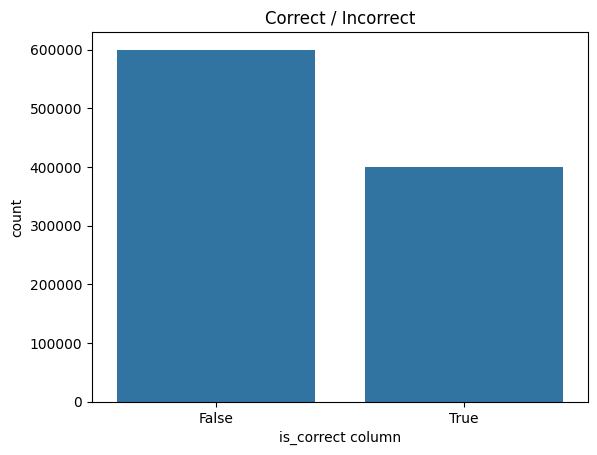

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Using seaborn
sns.countplot(x='is_correct', data=df)
plt.xlabel('is_correct column')
plt.ylabel('count')
plt.title('Correct / Incorrect')
plt.show()

In [ ]:
df.describe()

,question,is_correct,answer,solution
count,1000000,1000000,1000000,1000000
unique,12973,2,169004,999257
top,Compute $\dbinom{10}{8}$.,False,0,"<llm-code>\nfrom sympy import I, pi, exp, sqrt..."
freq,214,600000,25750,56


In [ ]:
category_counts = df['is_correct'].value_counts()

print(category_counts)

is_correct
False    600000
True     400000
Name: count, dtype: int64


In [ ]:
prompt = """You are a math expert who is always correct. Your task is to determine if a given answer to a math question is absolutely correct and check for any errors. Think about the question carefully and double check your answer. Your response should be "Correct" if the answer is accurate, and "Incorrect" if it is not.



### Question:
{}

### Answer:
{}

### Explanation:
{}

### Output:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    question = examples["question"]
    ans       = examples["answer"]
    output      = examples["is_correct"]
    explanation = examples["solution"]
    texts = []
    for instruction, input, output, explanation in zip(question, ans, output, explanation):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = prompt.format(instruction, input, explanation, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }




In [ ]:
import random

# Define the number of rows for training and testing
train_rows = 50000
test_rows = 1000
total_rows = train_rows + test_rows

# Randomly select 50,000 indices from the training set
random_indices = random.sample(range(len(dataset['train'])), total_rows)

# Split these indices into training and testing indices
train_indices = random_indices[:train_rows]
test_indices = random_indices[train_rows:]

# Select the subsets from the dataset
small_train_dataset = dataset['train'].select(train_indices)
small_test_dataset = dataset['train'].select(test_indices)

print("Small train dataset size:", len(small_train_dataset))
print("Small test dataset size:", len(small_test_dataset))

Small train dataset size: 50000
Small test dataset size: 1000


In [ ]:
# Process the training dataset and generate prompt for each datapoint
train_dataset_sm = small_train_dataset.map(formatting_prompts_func, batched = True,)
train_dataset = dataset['train'].map(formatting_prompts_func, batched = True,)

## SFT

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

training_args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 1100,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    )

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset_sm,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 4,
    packing = False, # Can make training 5x faster for short sequences.
    args = training_args
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 50,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 1,100
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,1.523800
2,1.832200
3,1.542500
4,1.322900
5,1.218600
6,0.930600
7,0.970600
8,0.851100
9,0.790600
10,0.778700


In [ ]:
trainer_stats

TrainOutput(global_step=1100, training_loss=0.6248046730865132, metrics={'train_runtime': 11691.2227, 'train_samples_per_second': 0.753, 'train_steps_per_second': 0.094, 'total_flos': 1.546336892954542e+17, 'train_loss': 0.6248046730865132, 'epoch': 0.176})

In [ ]:
average_training_loss = trainer_stats.training_loss
print(f"Average Training Loss: {average_training_loss}")


Average Training Loss: 0.6248046730865132


In [ ]:
# Accessing the training log history
log_history = trainer.state.log_history

# Extract loss values
losses = [entry['loss'] for entry in log_history if 'loss' in entry]
steps = list(range(1, len(losses) + 1))

# Print loss data
print(losses)

[1.5238, 1.8322, 1.5425, 1.3229, 1.2186, 0.9306, 0.9706, 0.8511, 0.7906, 0.7787, 0.689, 0.8046, 0.7431, 0.6442, 0.7896, 0.5642, 0.715, 0.5785, 0.7902, 0.7645, 0.5419, 0.5822, 0.6383, 0.8111, 0.6708, 0.7223, 0.6796, 0.7677, 0.6672, 0.6953, 0.7045, 0.5665, 0.7232, 0.7364, 0.8621, 0.6178, 0.7075, 0.6628, 0.5812, 0.7514, 0.5916, 0.5559, 0.6414, 0.636, 0.642, 0.69, 0.7081, 0.6779, 0.623, 0.6625, 0.6936, 0.664, 0.7049, 0.6447, 0.6229, 0.6464, 0.7183, 0.8491, 0.9333, 0.6689, 0.6442, 0.5567, 0.6417, 0.6258, 0.646, 0.6142, 0.6832, 0.6107, 0.6719, 0.6786, 0.5716, 0.561, 0.6229, 0.7505, 0.753, 0.5443, 0.6081, 0.6179, 0.7511, 0.5629, 0.6247, 0.7265, 0.6204, 0.5472, 0.6242, 0.6452, 0.6357, 0.6259, 0.6552, 0.7619, 0.743, 0.565, 0.6154, 0.6306, 0.5589, 0.706, 0.7238, 0.5576, 0.5774, 0.6457, 0.6963, 0.7545, 0.5718, 0.5845, 0.5682, 0.7674, 0.6506, 0.5901, 0.7141, 0.7399, 0.5844, 0.6936, 0.6426, 0.5459, 0.6299, 0.6679, 0.6857, 0.5162, 0.6496, 0.7636, 0.6469, 0.623, 0.6965, 0.5926, 0.698, 0.6721, 0.5976,

In [ ]:
losses_df = pd.DataFrame({
    "Losses": losses,
    "Steps": steps
})

losses_df.to_csv("losses.csv", index=False)
print("Submission file saved as 'losses.csv")

Submission file saved as 'losses.csv


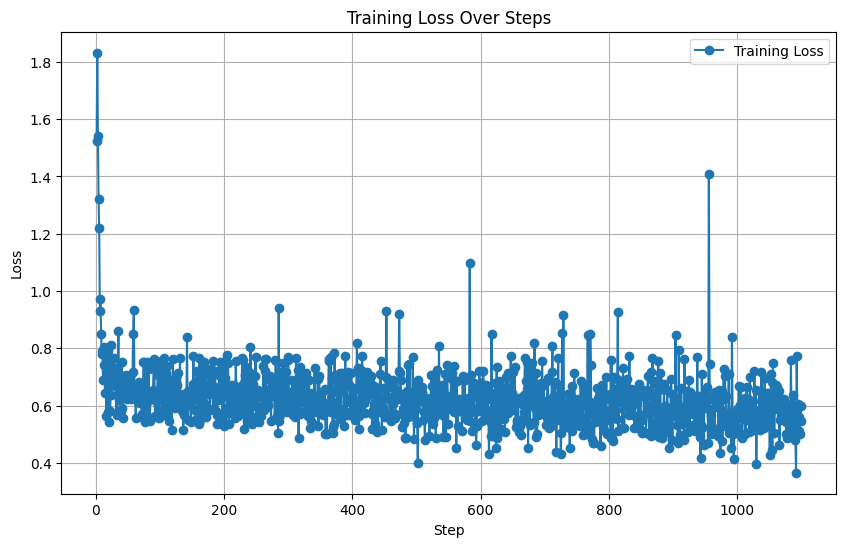

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, marker='o', linestyle='-', label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss Over Steps')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import pandas as pd

tokenizer.padding_side = 'left'

FastLanguageModel.for_inference(model)

prompt = """You are a math expert who is always correct. Your task is to determine if a given answer to a math question is absolutely correct and check for any errors. Think about the question carefully and double check your answer. Your response should be "Correct" if the answer is accurate, and "Incorrect" if it is not.

### Question:
{}

### Given Answer:
{}

### Solution:
{}

### Output:
"""

# Prepare prompts for each question-answer-solution
prompts = [
    prompt.format(question, answer, solution)
    for question, answer, solution in zip(sm_test_dataset['question'], sm_test_dataset['answer'], sm_test_dataset['solution'])
]


batch_size = 8
max_new_tokens = 10

# Collect predictions
results = []

# Run inference in batches
for start_idx in range(0, len(prompts), batch_size):
    # Prepare a batch of prompts
    batch_prompts = prompts[start_idx:start_idx + batch_size]
    # Tokenize with padding
    inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True).to("cuda")

    outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, use_cache=True)

    batch_responses = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    # Extract only the "True" or "False" part of each response
    for response in batch_responses:
        prediction_str = response.split("\n")[-1].strip()  # Get the last line
        prediction_bool = prediction_str == "True"  # Convert to boolean
        results.append(prediction_bool)

submission_df = pd.DataFrame({
    "ID": range(len(results)),
    "is_correct": results  # Already in boolean format (True or False)
})


submission_df.to_csv("sm_submission.csv", index=False)
print("Submission file saved as 'sm_submission.csv")

In [ ]:
test_dataset_sm = sm_test_dataset.map(formatting_prompts_func, batched = True,)

In [ ]:
# Load the CSV file containing the `True`/`False` values
csv_df = pd.read_csv("sm_submission.csv")

# Assume 'is_correct' column contains the True/False predictions
csv_list = csv_df['is_correct'].tolist()

# Define the other list of ground truth or expected True/False values
val_list = sm_test_dataset['is_correct']

# Check if the lists have the same length
if len(csv_list) != len(val_list):
    print("The lists have different lengths, cannot directly compare.")
else:
    # Calculate mismatches and accuracy
    mismatches = [i for i, (pred, truth) in enumerate(zip(csv_list, val_list)) if pred != truth]
    accuracy = 1 - len(mismatches) / len(val_list)

    print(f"Number of mismatches: {len(mismatches)}")
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Optional: Print mismatched indices and their values
    for idx in mismatches:
        print(f"Mismatch at index {idx}: CSV value = {csv_list[idx]}, Ground truth = {val_list[idx]}")


## inference

In [ ]:
# create test set variable
test_dataset = dataset['test']



In [ ]:

import pandas as pd

tokenizer.padding_side = 'left'

FastLanguageModel.for_inference(model)

prompt = """You are a math expert who is always correct. Your task is to determine if a given answer to a math question is absolutely correct and check for any errors. Think about the question carefully and double check your answer. Your response should be "Correct" if the answer is accurate, and "Incorrect" if it is not.

### Question:
{}

### Given Answer:
{}

### Solution:
{}

### Output:
"""

# Prepare prompts for each question-answer-solution
prompts = [
    prompt.format(question, answer, solution)
    for question, answer, solution in zip(test_dataset['question'], test_dataset['answer'], test_dataset['solution'])
]


batch_size = 8
max_new_tokens = 10

# Collect predictions
results = []

# Run inference in batches
for start_idx in range(0, len(prompts), batch_size):
    # Prepare a batch of prompts
    batch_prompts = prompts[start_idx:start_idx + batch_size]
    # Tokenize with padding
    inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True).to("cuda")

    outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, use_cache=True)

    batch_responses = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    # Extract only the "True" or "False" part of each response
    for response in batch_responses:
        prediction_str = response.split("\n")[-1].strip()  # Get the last line
        prediction_bool = prediction_str == "True"  # Convert to boolean
        results.append(prediction_bool)

submission_df = pd.DataFrame({
    "ID": range(len(results)),
    "is_correct": results  # Already in boolean format (True or False)
})


submission_df.to_csv("submission.csv", index=False)
print("Submission file saved as 'submission.csv")


Submission file saved as 'submission.csv


## saving model

In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

In [ ]:
if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference


==((====))==  Unsloth 2024.11.5: Fast Llama patching. Transformers = 4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu124. CUDA = 7.5. CUDA Toolkit = 12.4.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
